In [233]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
from prophet import Prophet
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

## Dataset and Analysis - For Sales Forecasting

The dataset is loaded and head is visualized

In [234]:
df = pd.read_csv('D:/datasets/Bakery sales.csv', index_col=0)
df.head()

,date,time,ticket_number,article,Quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


## Data Cleaning

Looking at dataset information and missing values are checked and some fields are formatted

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234005 entries, 0 to 511395
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  object 
dtypes: float64(2), object(4)
memory usage: 12.5+ MB


In [236]:
df.isnull().sum()

date             0
time             0
ticket_number    0
article          0
Quantity         0
unit_price       0
dtype: int64

In [237]:
df['Quantity'] = abs(df['Quantity'])

In [238]:
print("Dataset Description :\n", df['Quantity'].describe())

Dataset Description :
 count    234005.000000
mean          1.557189
std           1.266824
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         200.000000
Name: Quantity, dtype: float64


In [239]:
df['unit_price'] = (
    df['unit_price']
    .str.replace('€', '', regex=False)
    .str.replace('.', '', regex=False) 
    .str.replace(',', '.', regex=False)
    .astype(float))

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=False)

In [240]:
df['Sales'] = df['Quantity']*df['unit_price']

In [241]:
df['Sales'].describe()

count    234005.000000
mean          2.422139
std           2.603056
min           0.000000
25%           1.200000
50%           1.600000
75%           2.600000
max         200.000000
Name: Sales, dtype: float64

In [242]:
# df

## Final Dataset used for Training

In [243]:
final_df = df.groupby('date', as_index=False)['Sales'].sum()

In [244]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    600 non-null    datetime64[ns]
 1   Sales   600 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.5 KB


In [245]:
full_range = pd.date_range(start='2021-01-01', end=final_df["date"].max())

missing_dates = full_range.difference(final_df["date"])
missing_dates

DatetimeIndex(['2021-01-01', '2021-01-06', '2021-01-13', '2021-01-20',
               '2021-01-27', '2021-02-03', '2021-02-10', '2021-02-17',
               '2021-02-24', '2021-03-03', '2021-03-10', '2021-03-17',
               '2021-03-24', '2021-03-31', '2021-04-07', '2021-05-17',
               '2021-05-18', '2021-05-19', '2021-05-20', '2021-11-17',
               '2021-11-24', '2021-12-01', '2021-12-06', '2021-12-07',
               '2021-12-08', '2021-12-15', '2022-01-01', '2022-01-05',
               '2022-01-12', '2022-01-19', '2022-01-26', '2022-02-02',
               '2022-02-09', '2022-02-16', '2022-02-23', '2022-05-04',
               '2022-09-01', '2022-09-19'],
              dtype='datetime64[ns]', freq=None)

We find some missing dates in the sales data

## Holiday Analysis

This is a dataset that has bakery sales from from France. French holidays correlate to higher sales.

In [246]:
years = [2021,2022,2023]
holidays_df = make_holidays_df(year_list=years, country='FR')

In [247]:
import holidays
fr_holidays = holidays.FR()
holidays_missing = []
for date in missing_dates:
    if date in fr_holidays:
        holidays_missing.append(date)

print(holidays_missing)

[Timestamp('2021-01-01 00:00:00'), Timestamp('2022-01-01 00:00:00')]


We see that some holidays are missing in either 2022 or 2021 and it can be filled with the data for previous years. Here, I have used the 2022 dates for 2021(not commonly a good practice yet used here since we have no other similar measure) Other data could be filled with the median amount made. 

In [248]:
final_df['date'].min()

Timestamp('2021-01-02 00:00:00')

In [249]:
final_df['date'].max()

Timestamp('2022-09-30 00:00:00')

We do not have the data for New Year's day 2021 either as our data begins with Jan 2, 2021. So, we have no estimate for the amount of cakes sold on new year's day. So it is better to treat these two dates as special holidays and input the 85% Sales value by manual estimate and input the other dates with available values at previous year

#### Add the missing dates

In [250]:
final_df = final_df.set_index("date").reindex(full_range)
final_df.index.name = "date"
final_df = final_df.reset_index().rename(columns={"index": "date"})

In [251]:
final_df['Sales'].isnull().sum()

np.int64(38)

In [252]:
final_df[final_df['date'] == '2021-02-02']

,date,Sales
32,2021-02-02,411.35


In [253]:
final_df["sales_last_year"] = final_df["Sales"].shift(365)

In [254]:
final_df["filled_sales"] = final_df["Sales"].fillna(final_df["sales_last_year"])
final_df['Sales'] = final_df['filled_sales']
final_df = final_df.drop('filled_sales', axis=1)
final_df = final_df.drop('sales_last_year', axis=1)

In [255]:
final_df.loc[final_df['date']=='2021-01-01', 'Sales'] = final_df["Sales"].quantile(0.95)
final_df.loc[final_df['date']=='2022-01-01', 'Sales'] = final_df["Sales"].quantile(0.95)

In [256]:
final_df[(final_df['date']=='2022-01-01') | (final_df['date']=='2021-01-01')]

,date,Sales
0,2021-01-01,1918.2000
365,2022-01-01,1918.3575


In [257]:
final_df['Sales'].isnull().sum()

np.int64(25)

We filled 11 values for 2022 using 2021's data and 2 values using the Holiday estimate of 95th percentile. The rest can be handled by median filling

In [258]:
final_df['Sales'] = final_df['Sales'].fillna(final_df["Sales"].quantile(0.50))

In [259]:
final_df.isnull().sum()

date     0
Sales    0
dtype: int64

In [260]:
final_df['Sales'].median()

np.float64(767.4)

In [261]:
final_df.value_counts().sum()

np.int64(638)

## Visualization of Sales

In [262]:
px.area(final_df, x='date', y='Sales')

In [263]:
px.box(final_df['Sales'])

We cannot remove these outliers as these dates may be holidays or other special days where the amount of cakes sold is actually very large. So these outliers are to be considered as they mimic the real world data

In [264]:
fig = px.histogram(x=final_df['date'], y=final_df['Sales'], width=1200, height=450)
fig.update_layout(bargap=0.15, yaxis=dict(tickprefix='€'))
fig.show()


In [265]:
# final_df.to_csv("D:/Datasets/final_sales_data.csv")
# df = pd.read_csv("D:/Datasets/final_sales_data.csv")
# df = df.drop('Unnamed: 0', axis=1)
# df['date'] = pd.to_datetime(df['date'])
# df_monthly = (
#     df.groupby(pd.Grouper(key="date", freq="ME"))
#     .sum()
#     .reset_index()
# )
# df_monthly['Sales'] = df_monthly['Sales'].round(2)
# df_monthly.head()
# df_monthly.to_csv("D:/GenAIForecastExplain/monthly_data_cakes.csv")

In [266]:
forecast_days = 210

final_df = final_df[['date','Sales']].rename(columns={'date':'ds', 'Sales':'y'})
final_df = final_df.sort_values('ds')

final_df['is_may'] = (final_df['ds'].dt.month == 5).astype(int)
final_df['is_jul'] = (final_df['ds'].dt.month == 7).astype(int)
final_df['is_aug'] = (final_df['ds'].dt.month == 8).astype(int)

train_df = final_df[:-forecast_days]
test_df = final_df.iloc[-forecast_days:]

Seasonality for yearly, daily, holidays and weekends

In [267]:
# train_df['is_aug15'] = (train_df['ds'].dt.month == 8) & ((train_df['ds'].dt.day == 15) | (train_df['ds'].dt.day == 14)).astype(int)

In [268]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
totals = []

for i,day in enumerate(days):
    total = final_df.loc[(final_df['ds'].dt.dayofweek == i), 'y'].sum() #Monday is 0 and Sun is 6
    totals.append(round(total,2))

plot_df = pd.DataFrame({
    "Days":days,
    "Total_Cakes": totals
})

fig = px.bar(plot_df, x='Days', y='Total_Cakes', text='Total_Cakes',
             title='Total Cake Sales by Day of Week', 
             labels={'Total_Cakes':'Total Cake Sales', 'Total_Cakes':'Year'}
)

fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title='Total Cakes Sales', xaxis_title='Days', width=700, height=500)
fig.show()

In [269]:
totals = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(1, 13): 
    total = final_df.loc[(final_df['ds'].dt.month == i), 'y'].sum()
    totals.append(round(total, 2))

plot_df = pd.DataFrame({
    "Month": months,
    "Total_Cakes": totals
})

fig = px.bar(
    plot_df,
    x='Month',
    y='Total_Cakes',
    text='Total_Cakes',
    title='Total Cake Sales by Month',
    labels={'Total_Cakes': 'Total Cake Sales', 'Month': 'Month'}
)

fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title='Total Cake Sales', xaxis_title='Month', width=800, height=500)
fig.show()


In [270]:
total_2021 = final_df.loc[(final_df['ds'].dt.year == 2021) & (final_df['ds'].dt.month <= 9), 'y'].sum()
total_2022 = final_df.loc[(final_df['ds'].dt.year == 2022) & (final_df['ds'].dt.month <= 9), 'y'].sum()

plot_df = pd.DataFrame({
    'Year': ['2021', '2022'],
    'Total_Cakes': [round(total_2021,2), round(total_2022,2)]
})

# Plot bar chart
fig = px.bar(plot_df, x='Year', y='Total_Cakes', text='Total_Cakes',
             title='Total Cake Sales Jan-Sep: 2021 vs 2022', 
             labels={'Total_Cakes':'Total Cake Sales', 'Year':'Year'},
             color='Year')

fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title='Total Cakes Sales', xaxis_title='Year', width=700, height=500)
fig.show()

## Holidays Considered

In [271]:
print(holidays_df)

           ds          holiday
0  2021-01-01   New Year's Day
1  2021-04-05    Easter Monday
2  2021-05-24      Whit Monday
3  2021-05-01        Labor Day
4  2021-05-08      Victory Day
5  2021-05-13    Ascension Day
6  2021-07-14     National Day
7  2021-08-15   Assumption Day
8  2021-11-01  All Saints' Day
9  2021-11-11    Armistice Day
10 2021-12-25    Christmas Day
11 2022-01-01   New Year's Day
12 2022-04-18    Easter Monday
13 2022-06-06      Whit Monday
14 2022-05-01        Labor Day
15 2022-05-08      Victory Day
16 2022-05-26    Ascension Day
17 2022-07-14     National Day
18 2022-08-15   Assumption Day
19 2022-11-01  All Saints' Day
20 2022-11-11    Armistice Day
21 2022-12-25    Christmas Day
22 2023-01-01   New Year's Day
23 2023-04-10    Easter Monday
24 2023-05-29      Whit Monday
25 2023-05-01        Labor Day
26 2023-05-08      Victory Day
27 2023-05-18    Ascension Day
28 2023-07-14     National Day
29 2023-08-15   Assumption Day
30 2023-11-01  All Saints' Day
31 2023-

## Training Prophet Model

In [272]:
# final_df.info()

In [273]:
holidays_df['lower_window'] = -1  
holidays_df['upper_window'] = 0

prophet = Prophet(holidays=holidays_df,daily_seasonality=False,weekly_seasonality=False, yearly_seasonality=False)

prophet.add_seasonality(
    name='Weekly Seasonality',
    period=7,          
    fourier_order=5,   
    prior_scale = 20,    
    condition_name=None    
)

prophet.add_seasonality(
    name='Yearly Seasonality',
    period=365,          
    fourier_order=11,    
    prior_scale=20,    
    condition_name=None     
)

# prophet.add_seasonality(name='July',condition_name='is_jul', period=365, fourier_order=7)
# prophet.add_seasonality(name='Aug',condition_name='is_aug', period=365, fourier_order=7)

# prophet.add_country_holidays(country_name='FR')

prophet.add_seasonality(
    name='Weekly Seasonality',
    period=7,          
    fourier_order=5,   
    prior_scale = 20,    
    condition_name=None    
)

prophet.add_seasonality(
    name='Yearly Seasonality',
    period=365,          
    fourier_order=11,    
    prior_scale=20,    
    condition_name=None     
)

Currently, two seasonalities are used. Other seasonalities like a boosted sales in Jul and Aug was observed but they were not very conclusive as we had data for only two years. More data is required to validate the addition of anymore seasonalities.

In [274]:
prophet.fit(final_df)

20:18:39 - cmdstanpy - INFO - Chain [1] start processing
20:18:39 - cmdstanpy - INFO - Chain [1] done processing


In [275]:
future = prophet.make_future_dataframe(forecast_days)
future['month'] = future['ds'].dt.month
future['is_jul'] = (future['month'] == 7).astype(int)
future['is_aug'] = (future['month'] == 8).astype(int)

In [276]:
forecast = prophet.predict(future)
prophet_pred = forecast.set_index('ds').loc[test_df['ds'],['yhat','yhat_lower','yhat_upper']]

In [277]:
print("Prophet MAE:", mean_absolute_error(final_df['y'], forecast['yhat'][:-forecast_days]))
print("Prophet MAPE:", mean_absolute_percentage_error(final_df['y'], forecast['yhat'][:-forecast_days]))
print("Prophet R² :", r2_score(final_df['y'], forecast['yhat'][:-forecast_days]))

Prophet MAE: 129.33854064266464
Prophet MAPE: 0.15711514675402716
Prophet R² : 0.8464660099074532


I got a mean average percentage error of 15% for the forecast of 210 days(Jan-Sep 2022) with data from one year(2021).

## Cross Validation

This cross validation step uses a large initial data to monitor the impact of yearly seasonalities and predicts the sales for the months 06/2022-07/2022, 07/2022-08/2022, 08/2022-09/2022 and 09/2022 and evaluates it with the actual data.

In [278]:
df_cv = cross_validation(
    prophet,
    initial="510 days",
    period="30 days",
    horizon="30 days"
)

results = []

# Calculate average metrics per cutoff
for cutoff_date in df_cv['cutoff'].unique():
    subset = df_cv[df_cv['cutoff'] == cutoff_date]
    y_true = subset['y'].values
    y_pred = subset['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    results.append({'cutoff': cutoff_date, 'mae': mae, 'mape': mape, 'r2': r2})

# Create DataFrame with results
metrics_df = pd.DataFrame(results)

print(metrics_df)


  0%|          | 0/4 [00:00<?, ?it/s]20:18:40 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.09it/s]20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.23it/s]20:18:42 - cmdstanpy - INFO - Chain [1] start processing
20:18:42 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.28it/s]20:18:43 - cmdstanpy - INFO - Chain [1] start processing
20:18:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

      cutoff         mae       mape        r2
0 2022-06-02  103.964445  11.646446  0.835061
1 2022-07-02  229.743422  12.621027  0.535863
2 2022-08-01  215.465504  12.552668  0.709746
3 2022-08-31  136.231524  18.441535  0.493711


This cross-validation uses the same initial days but gives the performance metrics of each day of the forecasted sales for 30 days

In [279]:
# prophet.fit(final_df)
df_cv = cross_validation(
    prophet,
    initial="510 days",
    period="30 days",
    horizon="30 days"
)


  0%|          | 0/4 [00:00<?, ?it/s]20:18:43 - cmdstanpy - INFO - Chain [1] start processing
20:18:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.39it/s]20:18:44 - cmdstanpy - INFO - Chain [1] start processing
20:18:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.32it/s]20:18:45 - cmdstanpy - INFO - Chain [1] start processing
20:18:45 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.35it/s]20:18:45 - cmdstanpy - INFO - Chain [1] start processing
20:18:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


In [280]:
perf_df = performance_metrics(df_cv, rolling_window=0)

print(perf_df)

   horizon            mse        rmse         mae      mape     mdape  \
0   1 days   70532.627768  265.579795  242.165105  0.215962  0.218361   
1   2 days   24099.311552  155.239530  115.478923  0.139548  0.053769   
2   3 days   33250.533055  182.347287  160.114909  0.124123  0.108432   
3   4 days   58002.246745  240.836556  224.258625  0.190065  0.212642   
4   5 days    9089.378633   95.338233   71.781955  0.077158  0.042302   
5   6 days   44603.978026  211.196539  195.807653  0.191402  0.187338   
6   7 days   92932.618170  304.848517  224.930365  0.192832  0.231982   
7   8 days   34010.971816  184.420638  158.801779  0.144042  0.145315   
8   9 days   17091.116313  130.732996  117.979829  0.093697  0.098138   
9  10 days   30210.147770  173.810666  135.671505  0.097105  0.099958   
10 11 days   22852.869242  151.171655  129.981793  0.086509  0.080884   
11 12 days   30586.405378  174.889695  149.524973  0.097538  0.098393   
12 13 days  275868.963498  525.232295  419.176273  

In [281]:
perf_df = performance_metrics(df_cv, rolling_window=1)

print(perf_df)

  horizon          mse        rmse         mae      mape    mdape     smape  \
0 30 days  56903.21494  238.543948  171.351224  0.138154  0.12361  0.136357   

   coverage  
0     0.775  


performance_metrics(df_cv, rolling_window=0) then it will average over folds but not over time; so with 30 day horizon and daily data, you would have 30 rows, each of which is the average error across folds for points that were X days after the cutoff, where X is what is given in the horizon column of the output.

performance_metrics(df_cv, rolling_window=1), it would be more like a regular CV where the average is taken over all of the test-set points, so there will be a single row. This estimates the average forecast error over the entire 30-day horizon.

c:\Users\Radhesh.Rathnam\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



c:\Users\Radhesh.Rathnam\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\plot.py:548: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

C:\Users\Radhesh.Rathnam\AppData\Local\Temp\ipykernel_22404\2990483766.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



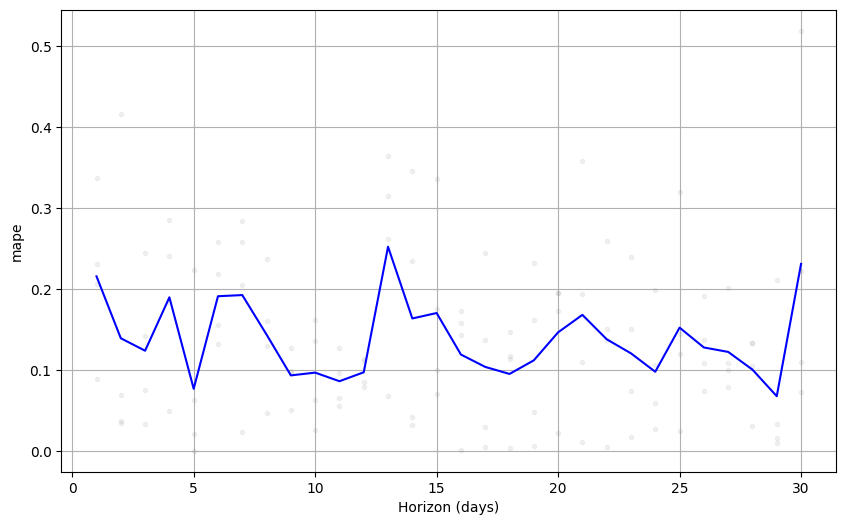

In [282]:
fig = plot_cross_validation_metric(df_cv, "mape", rolling_window=0)
fig.show()

Plotted the mape across the cross validated dataset

## Forecast Model Evaluation Visualizations

### Actual Sales vs Forecasted Sales and Predictions 

In [283]:
fig = px.line(forecast, x="ds", y="yhat", title="Prophet Forecast (35 Days)")
fig.add_scatter(x=final_df['ds'], y=final_df['y'], mode='lines', name="Actual")
fig.show()

### Actual Sales

In [284]:
px.line(final_df, x='ds', y='y')

### Forecasted Sales

In [285]:
px.line(forecast[:-forecast_days], x='ds', y='yhat')

Another visualization of Actual vs Forecasted Data

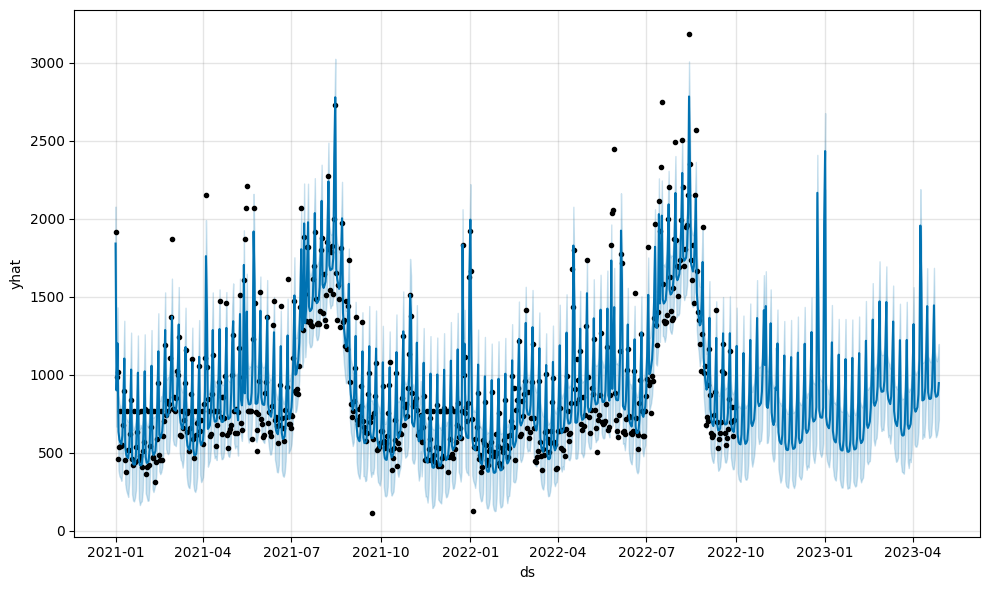

In [286]:
figure = prophet.plot(forecast, xlabel ='ds',ylabel='yhat')

### Components Plot that shows seasonalities

In [287]:
figure2 = plot_components_plotly(prophet,forecast)
figure2

## Monthly Average Sales from Actual Data

In [288]:
original = final_df[
    (final_df['ds'].dt.year.isin([2021, 2022])) &
    (final_df['ds'].dt.month.isin([1, 2, 3, 4, 10, 11, 12]))
].copy()

# Add Month column
original["Month"] = original["ds"].dt.strftime("%b")

# Group by month and compute average sales
original_monthly_avg = (
    original.groupby("Month")["y"]
    .mean()
    .reset_index()
    .sort_values(by="Month", key=lambda x: pd.Categorical(x, ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]))
)

original_monthly_avg['y'] = original_monthly_avg['y'].round(3)

print(original_monthly_avg)

  Month        y
6   Oct  738.956
5   Nov  662.268
1   Dec  743.892
3   Jan  645.571
2   Feb  720.620
4   Mar  713.807
0   Apr  856.773


## Monthly Average Sales from Daily Forecasted Sales

In [289]:
forecast_sub = forecast[
    (forecast['ds'].dt.year.isin([2022, 2023])) &
    (forecast['ds'].dt.month.isin([1, 2, 3, 4, 10, 11, 12]))
].copy()

forecast_sub["Month"] = forecast_sub["ds"].dt.strftime("%b")

forecast_monthly_avg = (
    forecast_sub.groupby("Month")["yhat"]
    .mean()
    .reset_index()
    .sort_values(by="Month", key=lambda x: pd.Categorical(x, ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]))
)

forecast_monthly_avg['yhat'] = forecast_monthly_avg['yhat'].round(3)

print(forecast_monthly_avg)


  Month     yhat
6   Oct  829.785
5   Nov  774.061
1   Dec  858.993
3   Jan  686.485
2   Feb  758.161
4   Mar  778.199
0   Apr  935.304


## Average Sales per month Compared

In [290]:
plot_df = original_monthly_avg.merge(forecast_monthly_avg, on="Month", how="inner")
plot_df_melt = plot_df.melt(id_vars="Month", value_vars=["y", "yhat"], var_name="Type", value_name="Avg_Sales")
plot_df_melt["Type"] = plot_df_melt["Type"].map({"y": "Actual(2021-2022)", "yhat": "Forecast(2022-2023)"})

fig = px.bar(
    plot_df_melt,
    x="Month",
    y="Avg_Sales",
    color="Type",
    barmode="stack",
    text="Avg_Sales",
    title="Average Sales (Actual vs Forecast)"
)
fig.show()

In [291]:
# import pickle
# filename = 'D:\GenAIForecastExplain\cake_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(prophet, file)

In [292]:
# holidays_df

In [293]:
# print(forecast[['ds','yhat']])

In [294]:
# print(final_df)

In [295]:
# holiday_names = [x for x in holidays_df['holiday']]
# for holiday in holiday_names:
#     holiday_names_in_forecast = forecast.columns[forecast.columns.str.startswith(holiday)].tolist()

# # Drop those columns
# forecast_no_holidays = forecast.drop(columns=holiday_names, axis=1)
# forecast_no_holidays[['ds','trend','yhat_upper','yhat','yhat_lower']]